# Prepration
## Imports

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style
from pdf2image import pdf2image

import hbsir

matplotlib.style.use("fivethirtyeight")

## Open The Report

In [2]:
try:
    with open("summary-results.pdf", mode="rb") as pdf_file:
        pdf_content = pdf_file.read()
except FileNotFoundError:
    import requests

    url = r"https://amar.org.ir/Portals/0/News/1402/hazineh%20daramad1401.pdf?ver=dqdR7ojDLzIyd13v3Xs7RA%3d%3d"
    report_file = requests.get(url)
    pdf_content = report_file.content
    with open("summary-results.pdf", mode="wb") as pdf_file:
        pdf_file.write(pdf_content)
report_pages = pdf2image.convert_from_bytes(pdf_content, dpi=100)

## Parameters

In [35]:
YEAR = 1401

## Functions

In [4]:
def wighted_avarage(table: pd.DataFrame) -> pd.Series:
    columns = [col for col in table.columns if col != "Weight"]
    table[columns] = table[columns].multiply(table["Weight"], axis="index")
    columns_summation = table.sum()
    results = columns_summation[columns].div(columns_summation["Weight"]).loc[columns]
    return results

# Household Income and Expenditure at a Glance
## Table 1
The total annual net and gross expenditures of urban and rural households on food, tobacco, and NonFood items for the years 1400 and 1401.

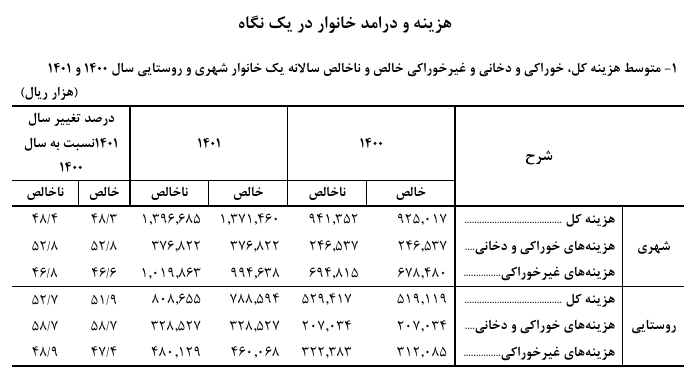

In [5]:
image = report_pages[4].crop((55, 130, 750, 520))
image

In [6]:
def sort_key(axis: pd.Index):
    sort_order = {
        "Total": 1,
        "Food": 2,
        "NonFood": 3,
        "Urban": 11,
        "Rural": 12,
        "Net": 21,
        "Gross": 22,
        1400: 31,
        1401: 32,
        "Percentage_Change": 33,
    }
    axis = axis.map(sort_order)
    axis = axis.astype(int)
    return axis

(
    hbsir.load_table("Expenditures", [YEAR-1, YEAR])
    .pipe(hbsir.add_classification, "Food_NonFood")
    .groupby(["Year", "ID", "Food_NonFood"])[["Gross_Expenditure", "Net_Expenditure"]].sum()
    .rename({"Gross_Expenditure": "Gross", "Net_Expenditure": "Net"}, axis="columns")
    .unstack()
    .pipe(lambda df: df.set_axis(df.columns.to_flat_index(), axis="columns"))
    .pipe(hbsir.add_weight)
    .pipe(
        lambda df: df.apply(lambda s: s.mul(df["Weight"]) if s.name != "Weight" else s)
    )
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .groupby(["Year", "Urban_Rural"]).sum()
    .pipe(
        lambda df: df.apply(lambda s: s.div(df["Weight"]) if s.name != "Weight" else s)
    )
    .drop(columns="Weight")
    .pipe(
        lambda df: df.set_axis(
            pd.MultiIndex.from_tuples(df.columns, names=["Net-Gross", "Food_NonFood"]),
            axis="columns",
        )
    )
    .stack(0)
    .eval("Total = Food + `NonFood`")
    .stack()

    .div(1000)
    .unstack("Year")
    .assign(Percentage_Change=lambda df: (df[YEAR] / df[YEAR-1] - 1) * 100)
    .unstack("Net-Gross")
    .sort_index(key=sort_key)
    .sort_index(key=sort_key, axis="columns")
    .style.format("{:,.0f}", subset=[YEAR-1, YEAR])
    .format("{:,.1f}", subset=["Percentage_Change"])
)

## Table 2
The annual income of urban and rural households for the years 1399 and 1400.

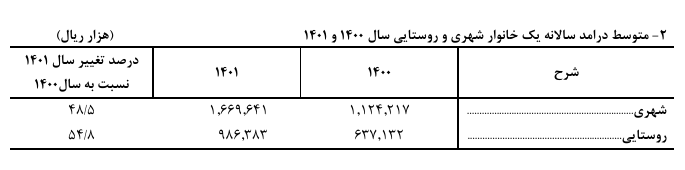

In [7]:
image = report_pages[4].crop((45, 520, 730, 690))
image

In [8]:
(
    hbsir.load_table("Total_Income", years=[YEAR-1, YEAR])
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .pipe(hbsir.add_weight)
    .assign(Weighted_Income=lambda t: t.eval("Income * Weight"))
    .groupby(["Year", "Urban_Rural"])[["Weighted_Income", "Weight"]].sum()
    .assign(Weighted_Income=lambda t: t.eval("Weighted_Income / Weight"))
    .loc[:, ["Weighted_Income"]]
    .div(1000)
    .unstack(0)
    .droplevel(0, axis="columns")
    .sort_index(ascending=False)
    .assign(Percentage_Change=lambda t: (t[YEAR] / t[YEAR-1] * 100) - 100)
    .style.format("{:,.0f}", subset=[YEAR-1, YEAR])
    .format("{:,.1f}", subset=["Percentage_Change"])
)

Year,1400,1401,Percentage_Change
Urban_Rural,,,
Urban,"1,124,158","1,669,639",48.5
Rural,"637,147","986,374",54.8


## Table 4

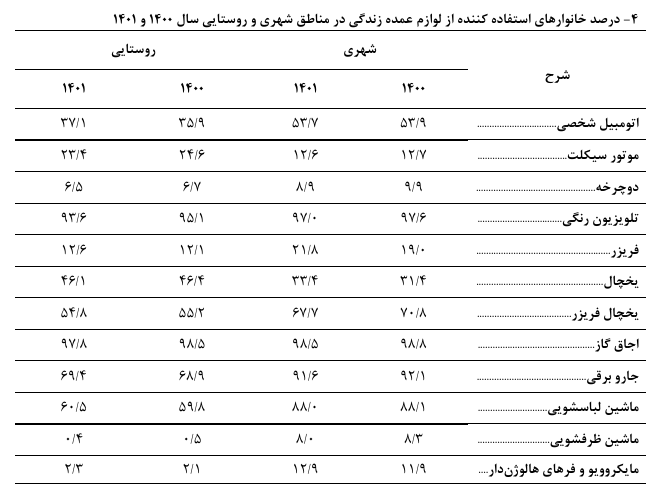

In [9]:
image = report_pages[5].crop((100, 150, 750, 650))
image

In [10]:
items = [
    "Car",
    "Motorcycle",
    "Bicycle",
    "TV_CR",
    "Freezer",
    "Refrigerator",
    "Frizer_Refrigrator",
    "Oven",
    "Vaccum",
    "Washing_Machine",
    "Dishwasher",
    "Microwave_Oven",
]
(
    hbsir.load_table("house_specifications", years=[YEAR-1, YEAR])
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .pipe(hbsir.add_weight)
    .astype({column: float for column in items})
    .eval("\n".join([f"{column} = {column} * Weight" for column in items]))
    .groupby(["Urban_Rural", "Year"])[items + ["Weight"]]
    .sum()
    .eval("\n".join([f"{column} = {column} / Weight * 100" for column in items]))
    .drop(columns="Weight")
    .T.sort_index(axis="columns", level="Year", sort_remaining=False)
    .sort_index(
        axis="columns", level="Urban_Rural", ascending=False, sort_remaining=False
    )
    .style.format("{:,.1f}")
)

## Table 5

### Table image

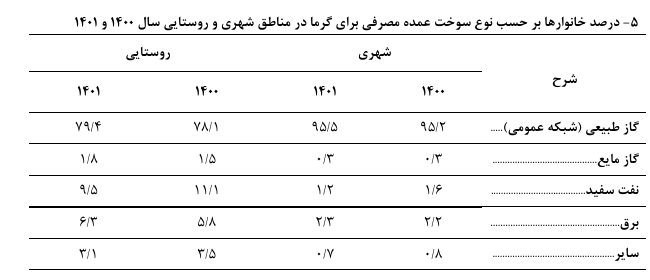

In [11]:
image = report_pages[5].crop((100, 670, 750, 950))
image

### Simple Replication

In [12]:
df = hbsir.load_table("house_specifications", years=[YEAR-1, YEAR])
df = hbsir.add_attribute(df, "Urban_Rural")
df = hbsir.add_weight(df)
filt = df["Heating_Fuel"].isin(["None", "Wood_and_Charcoal", "Gasoline", "Animal_Fuel", "Other_Fuel"])
df.loc[filt, "Heating_Fuel"] = "Other_Fuels"
df = df.groupby(["Year", "Urban_Rural", "Heating_Fuel"])[["Weight"]].sum()
df = df.join(df.groupby(["Year", "Urban_Rural"])["Weight"].transform("sum").rename("Weight_Sum"))
df = (df["Weight"] / df["Weight_Sum"] * 100).to_frame()
df = pd.pivot(df.reset_index(), index=["Heating_Fuel"], columns=["Urban_Rural", "Year"])
df = df.droplevel(0, axis="columns")
df = df.loc[
    ["Piped_Gas", "Liquid_Gas", "Karosine", "Electricity", "Other_Fuels"],
    [("Urban", 1400), ("Urban", 1401), ("Rural", 1400), ("Rural", 1401)]
]
df.style.format("{:,.1f}")

### Data Pipeline

In [13]:
(
    hbsir.load_table("house_specifications", years=[YEAR-1, YEAR])
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .pipe(hbsir.add_weight)
    .assign(
        Heating_Fuel=lambda df: df["Heating_Fuel"]
        .where(
            lambda s: s.isin(["Piped_Gas", "Liquid_Gas", "Karosine", "Electricity"]),
            "Other_Fules"
        )
    )
    .groupby(["Year", "Urban_Rural", "Heating_Fuel"])[["Weight"]].sum()
    .unstack([1, 0])
    .pipe(lambda df: df / df.sum() * 100)
    .sort_index(
        axis="columns",
        key=lambda s: s.map({"Urban": 0, "Rural": 1, 1400: 0, 1401: 1})
    )
    .sort_index(
        key=lambda s: s.map(
            {
                "Piped_Gas": 0,
                "Liquid_Gas": 1,
                "Karosine": 2,
                "Electricity": 3,
                "Other_Fules": 4
            }
        )
    )
    .style.format("{:,.1f}")
)

## Table 6

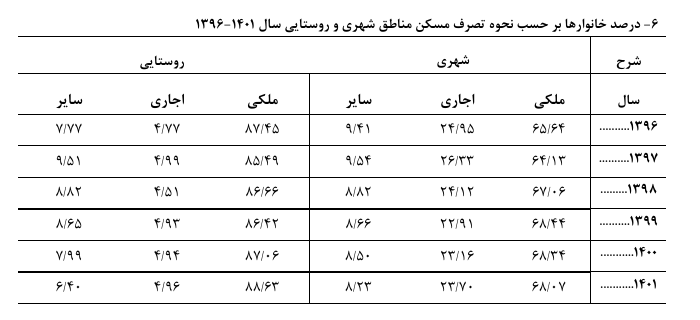

In [14]:
image = report_pages[6].crop((80, 130, 780, 450))
image

In [15]:
(
    hbsir.load_table("house_specifications", years=f"{YEAR-5}-{YEAR}")
    .assign(Tenure=lambda df: df["Tenure"].map({
        "Owned_Estate_Land": "Owned",
        "Owned_Estate": "Owned",
        "Rent": "Rent",
        "Mortgage": "Rent",
        "Service": "Other",
        "Free": "Other",
        "Other": "Other",
    }))
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .pipe(hbsir.add_weight)
    .groupby(["Year", "Urban_Rural", "Tenure"])[["Weight"]].sum()
    .unstack([0, 1])
    .droplevel(0, axis="columns")
    .pipe(lambda df: df / df.sum() * 100)
    .stack(0)
    .unstack(0)
    .sort_index(
        axis="columns",
        key=lambda s: s.map({"Urban": 0, "Rural": 1, "Owned": 0, "Rent": 1, "Other": 2})
    )
    .style.format("{:,.2f}")
)

# Table 10

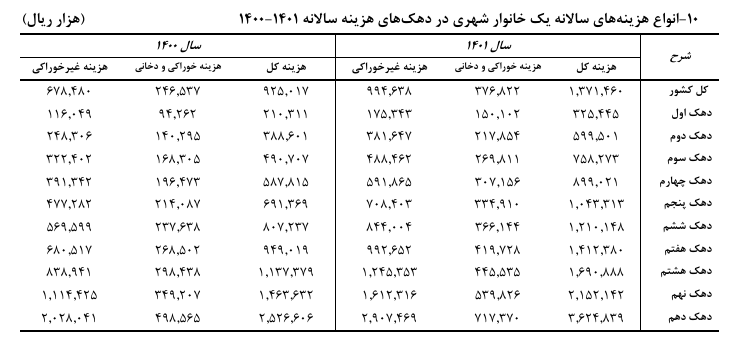

In [16]:
image = report_pages[11].crop((40, 150, 780, 490))
image

In [64]:
food_nonfood_expenditures = (
    hbsir.load_table("Expenditures", years=[YEAR-1, YEAR])
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .query("Urban_Rural=='Urban'")
    .pipe(hbsir.add_classification, "Food_NonFood")
    .groupby(["Year", "ID", "Food_NonFood"])["Net_Expenditure"].sum()
    .unstack()
    .pipe(hbsir.add_weight)
    .div(1000)
)
all_country = (
    food_nonfood_expenditures
    .assign()
    .groupby("Year").apply(wighted_avarage)
    .set_axis(
        pd.MultiIndex.from_product([["All"], [YEAR-1, YEAR]], names=["Decile", "Year"]),
        axis="index",
    )
    .rename_axis("Food_NonFood", axis="columns")
)
deciles = (
    food_nonfood_expenditures
    .join(
        hbsir.calculator.calculate_decile(
            on="Net_Expenditure",
            years=[YEAR-1, YEAR],
            weighted=True,
            groupby="Urban_Rural",
        )
    )
    .groupby(["Year", "Decile"]).apply(wighted_avarage)
    .loc[:, ["Food", "NonFood"]]
    .reorder_levels(["Decile", "Year"])
    .rename_axis("Food_NonFood", axis="columns")
)
urban_table = (
    pd.concat([all_country, deciles])
    .assign(Sum=lambda df: df.sum(axis="columns"))
    .unstack("Year")
    .reorder_levels([1, 0], axis="columns")
    .sort_index(axis="columns")
)
urban_table.style.format("{:,.0f}")

## Table 11

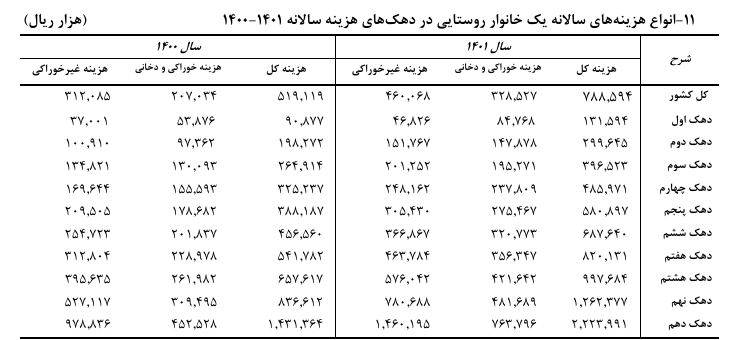

In [18]:
image = report_pages[11].crop((40, 520, 770, 860))
image

In [65]:
food_nonfood_expenditures = (
    hbsir.load_table("Expenditures", years=[YEAR-1, YEAR])
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .query("Urban_Rural=='Rural'")
    .pipe(hbsir.add_classification, "Food_NonFood")
    .groupby(["Year", "ID", "Food_NonFood"])["Net_Expenditure"].sum()
    .unstack()
    .pipe(hbsir.add_weight)
    .div(1000)
)
all_country = (
    food_nonfood_expenditures
    .assign()
    .groupby("Year").apply(wighted_avarage)
    .set_axis(
        pd.MultiIndex.from_product([["All"], [YEAR-1, YEAR]], names=["Decile", "Year"]),
        axis="index",
    )
    .rename_axis("Food_NonFood", axis="columns")
)
deciles = (
    food_nonfood_expenditures
    .join(
        hbsir.calculator.calculate_decile(
            on="Net_Expenditure",
            years=[YEAR-1, YEAR],
            weighted=True,
            groupby="Urban_Rural",
        )
    )
    .groupby(["Year", "Decile"]).apply(wighted_avarage)
    .loc[:, ["Food", "NonFood"]]
    .reorder_levels(["Decile", "Year"])
    .rename_axis("Food_NonFood", axis="columns")
)
rural_table = (
    pd.concat([all_country, deciles])
    .assign(Sum=lambda df: df.sum(axis="columns"))
    .unstack("Year")
    .reorder_levels([1, 0], axis="columns")
    .sort_index(axis="columns")
)
rural_table.style.format("{:,.0f}")

## Graph 7

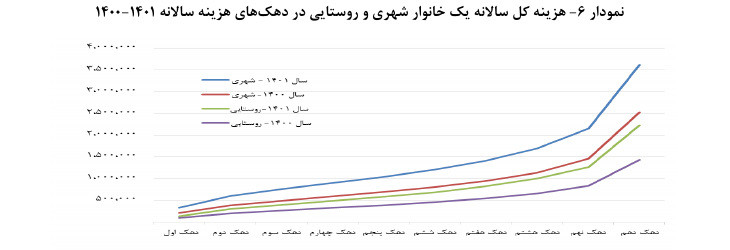

In [20]:
image = report_pages[11].crop((40, 870, 770, 1120))
image

<Axes: xlabel='Decile'>

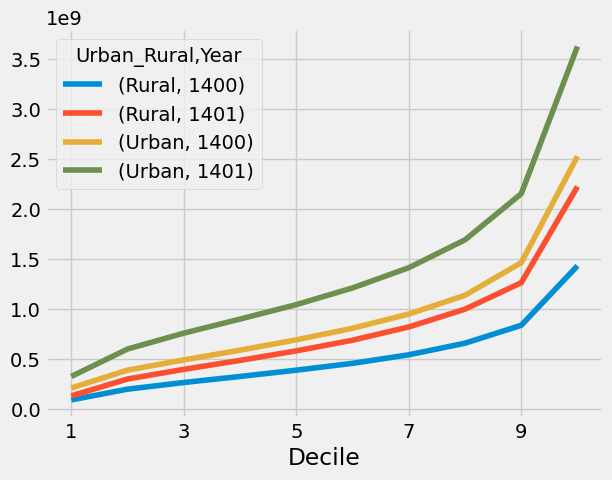

In [21]:
(
    pd.concat(
        [
            rural_table.loc[range(1, 11), (slice(None), "Sum")],
            urban_table.loc[range(1, 11), (slice(None), "Sum")],
        ],
        axis="columns",
        keys=["Rural", "Urban"],
        names=["Urban_Rural", "Year", "Food_NonFood"]
    )
    .droplevel(2, axis="columns")
    .plot.line()
)

## Table 12

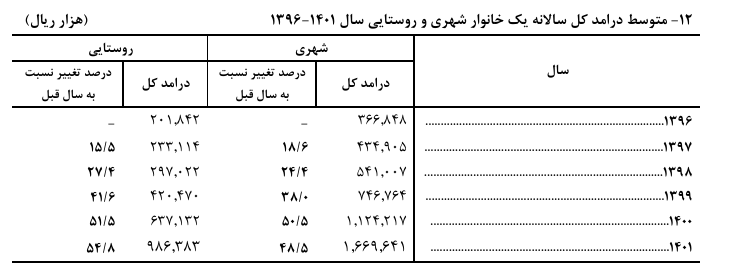

In [22]:
image = report_pages[12].crop((40, 480, 780, 760))
image

In [23]:
values = (
    hbsir.load_table("Total_Income", years=range(1395, 1402))
    .pipe(hbsir.add_weight)
    .set_index(["Year", "ID"])
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .groupby(["Year", "Urban_Rural"]).apply(wighted_avarage)
    .unstack()
    .div(1e3)
    .droplevel(0, axis="columns")
)

percents = values.div(values.shift(1)).sub(1).mul(100).round(1)

table = (
    pd.concat(
        [values, percents],
        axis="columns",
        keys=["Total_Income", "Percent"]
    )
    .loc[list(range(1396, 1402))]
    .reorder_levels([1, 0], axis="columns")
    .sort_index(axis="columns")
)

table.style.format("{:,.1f}")

## Graph 7

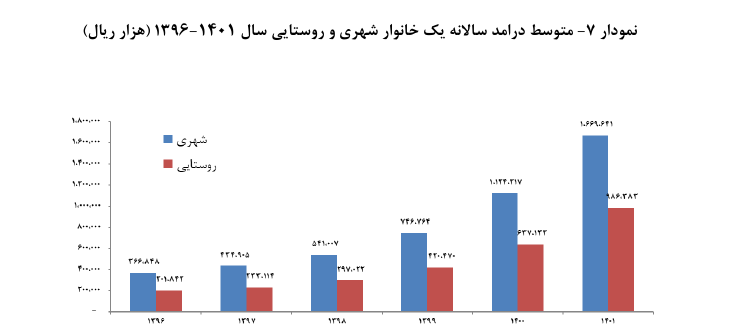

In [24]:
image = report_pages[12].crop((40, 770, 780, 1100))
image

<Axes: xlabel='Year'>

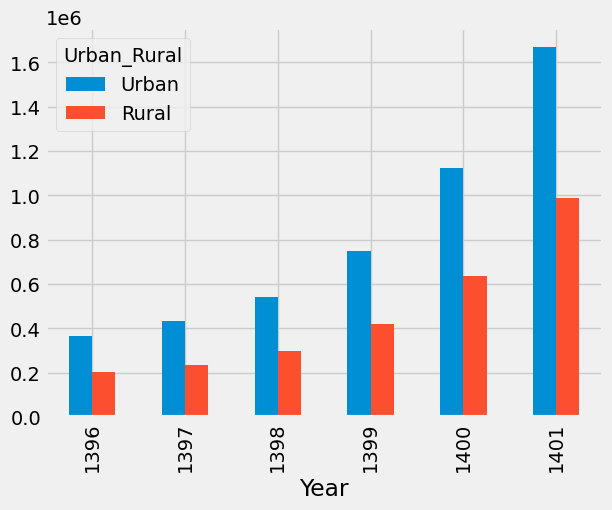

In [36]:
table.loc[:, (["Urban", "Rural"], "Total_Income")].droplevel(1, axis="columns").plot.bar()

## Graph 8

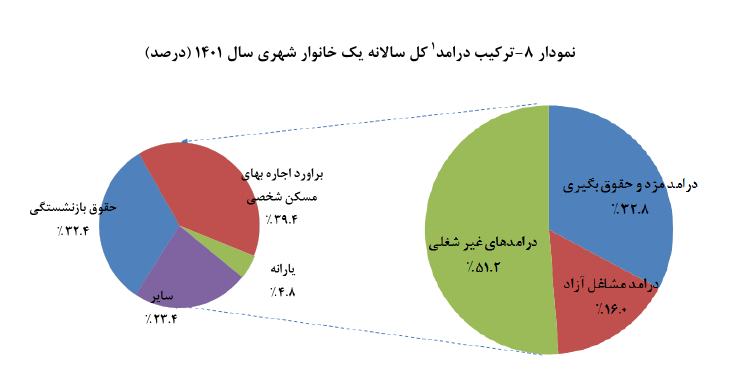

In [26]:
image = report_pages[13].crop((40, 150, 780, 530))
image

In [27]:
map_1 = {
    "Cash_Agricultural": "Self-Employed",
    "Cash_Aid": "Non-Work",
    "Cash_Cooperative": "Employment",
    "Cash_Home_Production": "Non-Work",
    "Cash_Interest": "Non-Work",
    "Cash_NonAgricultural": "Self-Employed",
    "Cash_Private": "Employment",
    "Cash_Public": "Employment",
    "Cash_Rent": "Non-Work",
    "Cash_Retirement": "Non-Work",
    "Cash_Subsidy": "Non-Work",
    "Cash_Transfer": "Non-Work",
    "NonCash_Agricultural": "Self-Employed",
    "NonCash_Cooperative": "Employment",
    "NonCash_Donation": "Non-Work",
    "NonCash_HomeProduction": "Non-Work",
    "NonCash_ImputedRent": "Non-Work",
    "NonCash_NonAgricultural": "Self-Employed",
    "NonCash_Private": "Employment",
    "NonCash_Public": "Employment",
}

map_2 = {
    "Cash_Aid": "Other",
    "Cash_Home_Production": "Other",
    "Cash_Interest": "Other",
    "Cash_Rent": "Other",
    "Cash_Retirement": "Retirement",
    "Cash_Subsidy": "Subsidy",
    "Cash_Transfer": "Other",
    "NonCash_Donation": "Other",
    "NonCash_HomeProduction": "Other",
    "NonCash_ImputedRent": "Imputed Rent",
}

In [28]:
plot_bata = (
    hbsir.load_table("Income_Breakdown", years=YEAR)
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .query("Urban_Rural == 'Urban'")
    .assign(
        plot_1 = lambda df: df["Income_Type"].map(map_1),
        plot_2 = lambda df: df["Income_Type"].map(map_2)
    )
    .pipe(hbsir.add_weight)
)
plot_parts = [
    (
        plot_bata
        .eval("Income = Income * Weight")
        .groupby("plot_1")[["Income"]].sum()
        .assign(
            number = lambda df: df.eval(f"Income = Income / {df['Income'].sum()} * 100"),
            label = lambda df: df.index + "\n" + df["number"].round(1).astype(str) + "%",
        )
        .loc[["Non-Work", "Self-Employed", "Employment"], ["number", "label"]]
    ),
    (
        plot_bata
        .eval("Income = Income * Weight")
        .dropna(subset=["plot_2"])
        .groupby("plot_2")[["Income"]].sum()
        .assign(
            number = lambda df: df.eval(f"Income = Income / {df['Income'].sum()} * 100"),
            label = lambda df: df.index + "\n" + df["number"].round(1).astype(str) + "%",
        )
        .loc[["Imputed Rent", "Retirement", "Other", "Subsidy"], ["number", "label"]]
    )
]

Text(4.6, -1.5, '')

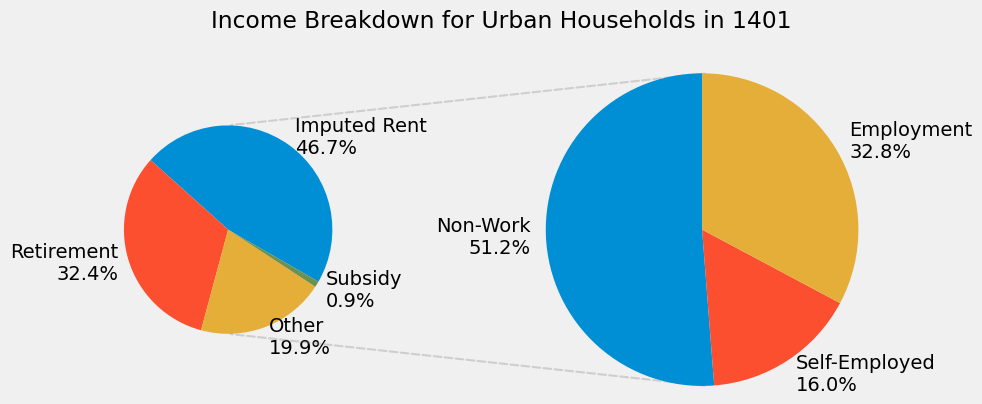

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax2.pie(plot_parts[0]["number"], labels=plot_parts[0]["label"], startangle=90, radius=1.5)
ax1.pie(plot_parts[1]["number"], labels=plot_parts[1]["label"], startangle=-30)

fig.suptitle(f"Income Breakdown for Urban Households in {YEAR}", y=0.9)
fig.tight_layout(pad=1)
ax1.annotate(
    xy = (0, 1),
    xytext = (4.6, 1.5),
    text = "",
    
    arrowprops = dict(
        color = "gray",
        linestyle = "--",
        arrowstyle = "-",
        linewidth = 1.5,
        alpha = 0.3,
    )
)
ax1.annotate(
    xy = (0, -1),
    xytext = (4.6, -1.5),
    text = "",
    arrowprops = dict(
        color = "gray",
        linestyle = "--",
        arrowstyle = "-",
        linewidth = 1.5,
        alpha = 0.3,
    )
)